In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from os import listdir
from bs4 import BeautifulSoup

train_pos_path = './aclImdb/train/pos/'
train_neg_path = './aclImdb/train/neg/'

test_pos_path = './aclImdb/test/pos/'
test_neg_path = './aclImdb/test/neg/'

In [3]:
def readPath(path):
    texts = []
    for file in sorted(listdir(path)):
        filename = path+file
        with open(filename) as f:
#             texts.append(f.read())

            # remove html tags
            texts.append(BeautifulSoup(f.read(), "lxml").text)
    return texts

In [4]:
from sklearn.model_selection import train_test_split

train_data = []
train_data.extend(readPath(train_pos_path))
train_data.extend(readPath(train_neg_path))
train_targets = []
train_targets.extend([1]*12500)
train_targets.extend([0]*12500)

train_data, val_data, train_targets, val_targets = train_test_split(
    train_data, train_targets, test_size=0.2, random_state=42)

test_data = [] 
test_data.extend(readPath(test_pos_path))
test_data.extend(readPath(test_neg_path))
test_targets = []
test_targets.extend([1]*12500)
test_targets.extend([0]*12500)

In [5]:
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [6]:
# Random sample from train dataset
import random

sampleIdx = random.randint(0, len(train_data) - 1)
print (train_data[sampleIdx])
print (train_targets[sampleIdx])
# print (BeautifulSoup(train_data[sampleIdx], "lxml").text)
# print (tokenize(BeautifulSoup(train_data[sampleIdx], "lxml").text))

I originally gave this episode a rating of two- I now wish I'd thought more about it. I also wish they had negative rating options.Watching it, I was amazed at how poor the whole thing was from start to finish. I adore Ron Pearlman, and John Carpenter... so what went wrong?? Last season episode 13 was pulled due to the way it handled the abortion issue. I think that this season Mr Carpenter managed to make something so grey-area that you can't immediately see if he is pro-choice or anti-abortion. It was only after I sat and thought about it that I realized he is very much anti-abortion- you get this most clearly in the end when the 'Mother' shoots the baby and kills it, to the dismay of the 'Father', who walks off in grief, leaving the mother unharmed. But you also see it in the way the Ron P. character is treated- I hardly think that if someone has proved themselves enough of a threat in the past so as to have a restraining order against him that they would not immediately be ringing 

In [7]:
# Let's write the tokenization function 

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# Example
tokens = tokenize(train_data[sampleIdx])
print (tokens)

['i', 'originally', 'gave', 'this', 'episode', 'a', 'rating', 'of', 'two-', 'i', 'now', 'wish', 'i', "'d", 'thought', 'more', 'about', 'it', 'i', 'also', 'wish', 'they', 'had', 'negative', 'rating', 'options', 'watching', 'it', 'i', 'was', 'amazed', 'at', 'how', 'poor', 'the', 'whole', 'thing', 'was', 'from', 'start', 'to', 'finish', 'i', 'adore', 'ron', 'pearlman', 'and', 'john', 'carpenter', '...', 'so', 'what', 'went', 'wrong', 'last', 'season', 'episode', '13', 'was', 'pulled', 'due', 'to', 'the', 'way', 'it', 'handled', 'the', 'abortion', 'issue', 'i', 'think', 'that', 'this', 'season', 'mr', 'carpenter', 'managed', 'to', 'make', 'something', 'so', 'grey', 'area', 'that', 'you', 'ca', "n't", 'immediately', 'see', 'if', 'he', 'is', 'pro', 'choice', 'or', 'anti', 'abortion', 'it', 'was', 'only', 'after', 'i', 'sat', 'and', 'thought', 'about', 'it', 'that', 'i', 'realized', 'he', 'is', 'very', 'much', 'anti', 'abortion-', 'you', 'get', 'this', 'most', 'clearly', 'in', 'the', 'end', '

In [8]:
# Alternatively try running the following multi-threaded version of tokenization
# Credit to Ilya Kulikov
from tqdm import tqdm_notebook

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def lower_case(parsed):
    return [token.text.lower() for token in parsed]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case_remove_punc(sample)
#         tokens = lower_case(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [32]:
import pickle as pkl

# val set tokens
print ("Tokenizing val data")
val_data_tokens_, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens_, _ = tokenize_dataset(test_data)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens_, all_train_tokens_ = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data


Tokenizing test data


Tokenizing train data


In [10]:
def ngrams(data_tokens, n):
    token_dataset = []
    all_tokens = []
    for tokens in data_tokens:
        token = [tuple([tokens[j] for j in range(i, i+n)])
                  for i in range(len(tokens)-n+1)]
        token_dataset.append(token)
        all_tokens += token
    return token_dataset, all_tokens

In [11]:
def ngrams_inclusive(data_tokens, n):
    token_dataset = []
    all_tokens = []
    for tokens in data_tokens:
        token_ = []
        for ng in range(1, n+1):
            token = [tuple([tokens[j] for j in range(i, i+ng)])
                      for i in range(len(tokens)-ng+1)]
            token_ += token
            all_tokens += token
        token_dataset.append(token_)
    return token_dataset, all_tokens

In [12]:
import pickle as pkl
# Then, load preprocessed train, val and test datasets
# train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
# all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

# val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
# test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
# print ("Train dataset size is {}".format(len(train_data_tokens)))
# print ("Val dataset size is {}".format(len(val_data_tokens)))
# print ("Test dataset size is {}".format(len(test_data_tokens)))

# print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

In [13]:
# N = 1
# # train_data_tokens, all_train_tokens = ngrams(train_data_tokens, N)
# # val_data_tokens, _ = ngrams(val_data_tokens, N)
# # test_data_tokens, _ = ngrams(test_data_tokens, N)
# train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens, N)
# val_data_tokens, _ = ngrams_inclusive(val_data_tokens, N)
# test_data_tokens, _ = ngrams_inclusive(test_data_tokens, N)

Now, we are going to create the vocabulary of most common 10,000 tokens in the training set.

In [14]:
# train_data_tokens[0][:10]

In [15]:
from collections import Counter

# max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# token2id, id2token = build_vocab(all_train_tokens)

In [16]:
# id2token[:10]

In [17]:
# Lets check the dictionary by loading random token from it

# random_token_id = random.randint(0, len(id2token)-1)
# random_token = id2token[random_token_id]

# print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
# print ("Token {}; token id {}".format(random_token, token2id[random_token]))

In [18]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

# train_data_indices = token2index_dataset(train_data_tokens)
# val_data_indices = token2index_dataset(val_data_tokens)
# test_data_indices = token2index_dataset(test_data_tokens)

# double checking
# print ("Train dataset size is {}".format(len(train_data_indices)))
# print ("Val dataset size is {}".format(len(val_data_indices)))
# print ("Test dataset size is {}".format(len(test_data_indices)))

Now we are going to create PyTorch DataLoader 

In [19]:
# MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, MAX_SENTENCE_LENGTH):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.MAX_SENTENCE_LENGTH = MAX_SENTENCE_LENGTH
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:self.MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

# BATCH_SIZE = 32
# train_dataset = NewsGroupDataset(train_data_indices, train_targets)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=True)

# val_dataset = NewsGroupDataset(val_data_indices, val_targets)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=True)

# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)

# for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

Here we will define Bag-of-Words model in PyTorch

In [62]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# emb_dim = 100
# model = BagOfWords(len(id2token), emb_dim)

In [21]:
# learning_rate = 0.01
# num_epochs = 3 # number epoch to train

# # Criterion and Optimizer and scheduler
# criterion = torch.nn.CrossEntropyLoss()  

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# val_acc_values = []
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, (data, lengths, labels) in enumerate(train_loader):
#         model.train()
#         data_batch, length_batch, label_batch = data, lengths, labels
#         optimizer.zero_grad()
#         outputs = model(data_batch, length_batch)
#         loss = criterion(outputs, label_batch)
#         running_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         # validate every 100 iterations
#         if i > 0 and i % 100 == 0:
# #             scheduler.step(running_loss)
#             # validate
#             val_acc = test_model(val_loader, model)
#             val_acc_values.append(val_acc)
#             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
#                         epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

# #             trn_acc = test_model(train_loader, model)
# #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
# #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
#             running_loss = 0.0

## Experiment for using only N-grams or 1-gram to N-grams

In [37]:
N = 4
# train_data_tokens, all_train_tokens = ngrams(train_data_tokens_, N)
# val_data_tokens, _ = ngrams(val_data_tokens_, N)
# test_data_tokens, _ = ngrams(test_data_tokens_, N)
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)

max_vocab_size = 20000
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

MAX_SENTENCE_LENGTH = 1200
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 3 # number epoch to train

# Criterion and Optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

val_acc_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
#             scheduler.step(running_loss)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_values.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

#             trn_acc = test_model(train_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
#                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
            running_loss = 0.0

Epoch: [1/3], Step: [101/625], Loss: 71.8028, Val Acc: 58.34
Epoch: [1/3], Step: [201/625], Loss: 49.6149, Val Acc: 85.14
Epoch: [1/3], Step: [301/625], Loss: 35.7458, Val Acc: 87.52
Epoch: [1/3], Step: [401/625], Loss: 31.4794, Val Acc: 88.66
Epoch: [1/3], Step: [501/625], Loss: 29.8321, Val Acc: 88.96
Epoch: [1/3], Step: [601/625], Loss: 28.4607, Val Acc: 89.52
Epoch: [2/3], Step: [101/625], Loss: 18.9539, Val Acc: 89.82
Epoch: [2/3], Step: [201/625], Loss: 18.2839, Val Acc: 89.84
Epoch: [2/3], Step: [301/625], Loss: 20.7285, Val Acc: 89.7
Epoch: [2/3], Step: [401/625], Loss: 18.7844, Val Acc: 90.12
Epoch: [2/3], Step: [501/625], Loss: 20.1849, Val Acc: 90.2
Epoch: [2/3], Step: [601/625], Loss: 20.1471, Val Acc: 90.04
Epoch: [3/3], Step: [101/625], Loss: 11.6257, Val Acc: 89.92
Epoch: [3/3], Step: [201/625], Loss: 11.3600, Val Acc: 90.0
Epoch: [3/3], Step: [301/625], Loss: 11.3979, Val Acc: 90.44
Epoch: [3/3], Step: [401/625], Loss: 11.6594, Val Acc: 89.76
Epoch: [3/3], Step: [501/62

In [38]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 88.94
Test Acc 87.32


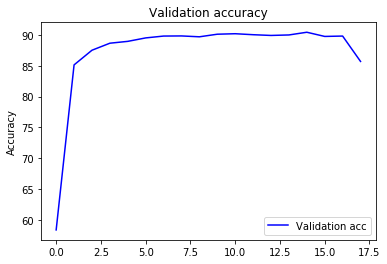

In [42]:
plt.clf()
plt.plot(val_acc_values, 'b', label='Validation acc')
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Experiment for choosing N for N-grams

In [43]:
Ngrams_param = [
    (1, 200),
    (2, 500),
    (3, 800),
    (4, 1200)
]
tt = []
for (N, MAX_SENTENCE_LENGTH) in Ngrams_param:
    t1 = []
    t1.append(N)
    tt.append(t1)
print(tt)

[[1], [2], [3], [4]]


In [44]:
val_acc_total = []
for (N, MAX_SENTENCE_LENGTH) in Ngrams_param:
#     N = 4
    train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
    val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
    test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)

    max_vocab_size = 10000
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)

#     MAX_SENTENCE_LENGTH = 1200
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.01
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
    #             scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                            epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total.append(val_acc_values)

Epoch: [1/10], Step: [101/625], Loss: 79.7812, Val Acc: 77.06
Epoch: [1/10], Step: [201/625], Loss: 42.9531, Val Acc: 83.96
Epoch: [1/10], Step: [301/625], Loss: 35.8365, Val Acc: 85.42
Epoch: [1/10], Step: [401/625], Loss: 33.8468, Val Acc: 84.08
Epoch: [1/10], Step: [501/625], Loss: 32.7603, Val Acc: 84.26
Epoch: [1/10], Step: [601/625], Loss: 32.9489, Val Acc: 87.0
Epoch: [2/10], Step: [101/625], Loss: 21.0800, Val Acc: 87.02
Epoch: [2/10], Step: [201/625], Loss: 22.4955, Val Acc: 86.98
Epoch: [2/10], Step: [301/625], Loss: 23.3667, Val Acc: 86.66
Epoch: [2/10], Step: [401/625], Loss: 22.5790, Val Acc: 87.18
Epoch: [2/10], Step: [501/625], Loss: 22.9697, Val Acc: 87.16
Epoch: [2/10], Step: [601/625], Loss: 25.3644, Val Acc: 87.04
Epoch: [3/10], Step: [101/625], Loss: 15.1764, Val Acc: 86.98
Epoch: [3/10], Step: [201/625], Loss: 14.6835, Val Acc: 86.38
Epoch: [3/10], Step: [301/625], Loss: 15.6447, Val Acc: 86.7
Epoch: [3/10], Step: [401/625], Loss: 18.3233, Val Acc: 86.36
Epoch: [3/

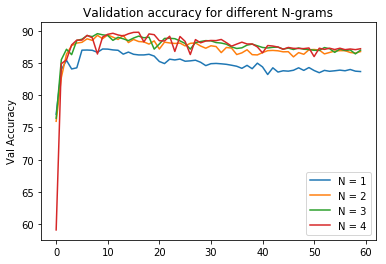

In [49]:
plt.clf()

for i in range(len(val_acc_total)):
    plt.plot(val_acc_total[i], label='N = %d' % (i+1))
    
plt.title('Validation accuracy for different N-grams')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('ngram.png')
plt.show()

## Experiment for vocabulary size

In [53]:
N = 4
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
MAX_SENTENCE_LENGTH = 1200

In [54]:
max_vocab_sizes = [5000, 10000, 20000, 40000]

In [55]:
val_acc_total = []
for max_vocab_size in max_vocab_sizes:
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)

    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.01
    num_epochs = 8 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
    #             scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                if len(train_loader) - i < 100:
                    print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                                epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total.append(val_acc_values)

Epoch: [1/8], Step: [601/625], Loss: 30.3186, Val Acc: 87.62
Epoch: [2/8], Step: [601/625], Loss: 26.0364, Val Acc: 88.6
Epoch: [3/8], Step: [601/625], Loss: 23.4334, Val Acc: 87.62
Epoch: [4/8], Step: [601/625], Loss: 20.9664, Val Acc: 88.44
Epoch: [5/8], Step: [601/625], Loss: 19.7768, Val Acc: 88.04
Epoch: [6/8], Step: [601/625], Loss: 20.4185, Val Acc: 83.58
Epoch: [7/8], Step: [601/625], Loss: 18.6522, Val Acc: 87.58
Epoch: [8/8], Step: [601/625], Loss: 16.9561, Val Acc: 86.36
Epoch: [1/8], Step: [601/625], Loss: 31.5224, Val Acc: 88.78
Epoch: [2/8], Step: [601/625], Loss: 22.3072, Val Acc: 88.4
Epoch: [3/8], Step: [601/625], Loss: 17.7144, Val Acc: 89.0
Epoch: [4/8], Step: [601/625], Loss: 18.1845, Val Acc: 88.82
Epoch: [5/8], Step: [601/625], Loss: 12.8533, Val Acc: 87.84
Epoch: [6/8], Step: [601/625], Loss: 9.9201, Val Acc: 88.36
Epoch: [7/8], Step: [601/625], Loss: 9.9086, Val Acc: 87.66
Epoch: [8/8], Step: [601/625], Loss: 7.0985, Val Acc: 87.16
Epoch: [1/8], Step: [601/625],

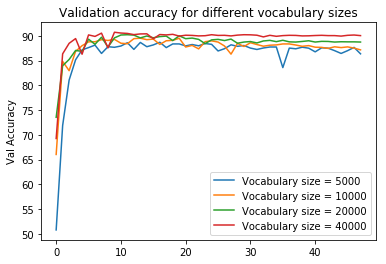

In [56]:
plt.clf()

for i in range(len(val_acc_total)):
    plt.plot(val_acc_total[i], label='Vocabulary size = %d' % max_vocab_sizes[i])
    
plt.title('Validation accuracy for different vocabulary sizes')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('voc_size.png')
plt.show()

## Experiment for embedding size

In [57]:
N = 4
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
MAX_SENTENCE_LENGTH = 1200
max_vocab_size = 40000

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

In [58]:
emb_dims = [50, 100, 200, 400]

In [60]:
val_acc_total = []
for emb_dim in emb_dims:
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.01
    num_epochs = 8 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
    #             scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                if len(train_loader) - i < 100:
                    print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                                epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total.append(val_acc_values)

Epoch: [1/8], Step: [601/625], Loss: 27.8666, Val Acc: 88.56
Epoch: [2/8], Step: [601/625], Loss: 17.1870, Val Acc: 90.92
Epoch: [3/8], Step: [601/625], Loss: 7.7410, Val Acc: 90.86
Epoch: [4/8], Step: [601/625], Loss: 4.1354, Val Acc: 90.46
Epoch: [5/8], Step: [601/625], Loss: 1.3143, Val Acc: 90.22
Epoch: [6/8], Step: [601/625], Loss: 0.6798, Val Acc: 90.26
Epoch: [7/8], Step: [601/625], Loss: 0.3157, Val Acc: 90.42
Epoch: [8/8], Step: [601/625], Loss: 0.1922, Val Acc: 90.1
Epoch: [1/8], Step: [601/625], Loss: 27.0779, Val Acc: 90.12
Epoch: [2/8], Step: [601/625], Loss: 12.9351, Val Acc: 90.96
Epoch: [3/8], Step: [601/625], Loss: 6.4808, Val Acc: 90.56
Epoch: [4/8], Step: [601/625], Loss: 1.5511, Val Acc: 90.14
Epoch: [5/8], Step: [601/625], Loss: 0.5035, Val Acc: 90.22
Epoch: [6/8], Step: [601/625], Loss: 0.2371, Val Acc: 90.24
Epoch: [7/8], Step: [601/625], Loss: 0.2156, Val Acc: 90.18
Epoch: [8/8], Step: [601/625], Loss: 0.1687, Val Acc: 90.32
Epoch: [1/8], Step: [601/625], Loss: 

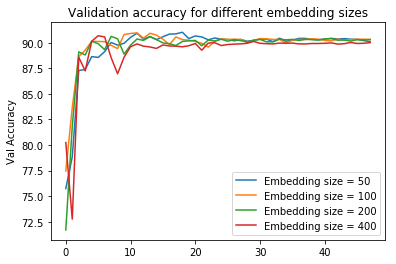

In [63]:
plt.clf()

for i in range(len(val_acc_total)):
    plt.plot(val_acc_total[i], label='Embedding size = %d' % emb_dims[i])
    
plt.title('Validation accuracy for different embedding sizes')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('emb_size.png')
plt.show()

## Experiment for Optimizers

In [68]:
N = 1
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
MAX_SENTENCE_LENGTH = 200
max_vocab_size = 10000

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

emb_dims = 50

In [83]:
# optimizers = ['adam', 'sgd']
optimizers = ['sgd']

In [ ]:
val_acc_total = []

In [87]:
for opt in optimizers:
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    model = BagOfWords(len(id2token), emb_dim)

    learning_rate = 0.5
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    if opt is 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif opt is 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
    #             scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                if len(train_loader) - i < 100:
                    print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                                epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total.append(val_acc_values)

Epoch: [1/10], Step: [601/625], Loss: 52.8867, Val Acc: 74.04
Epoch: [2/10], Step: [601/625], Loss: 50.0436, Val Acc: 75.24
Epoch: [3/10], Step: [601/625], Loss: 48.8153, Val Acc: 75.7
Epoch: [4/10], Step: [601/625], Loss: 44.4639, Val Acc: 78.46
Epoch: [5/10], Step: [601/625], Loss: 44.6653, Val Acc: 77.1
Epoch: [6/10], Step: [601/625], Loss: 43.1931, Val Acc: 78.36
Epoch: [7/10], Step: [601/625], Loss: 41.0891, Val Acc: 80.18
Epoch: [8/10], Step: [601/625], Loss: 41.8170, Val Acc: 80.36
Epoch: [9/10], Step: [601/625], Loss: 41.6292, Val Acc: 79.78
Epoch: [10/10], Step: [601/625], Loss: 37.3721, Val Acc: 79.72


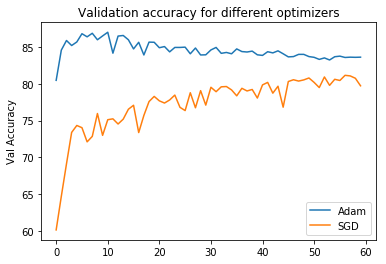

In [90]:
plt.clf()

plt.plot(val_acc_total[0], label='Adam')
plt.plot(val_acc_total[1], label='SGD')
    
plt.title('Validation accuracy for different optimizers')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('optimizer.png')
plt.show()

## Experiment for LR

In [91]:
N = 4
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
MAX_SENTENCE_LENGTH = 1200
max_vocab_size = 40000

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

In [109]:
lrs = [0.01, 0.1, 0.5]

In [95]:
val_acc_total = []

In [ ]:
for learning_rate in lrs:
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    model = BagOfWords(len(id2token), emb_dim)

    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                if len(train_loader) - i < 100:
                    print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                                epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total.append(val_acc_values)

In [129]:
len(val_acc_total_backup)

4

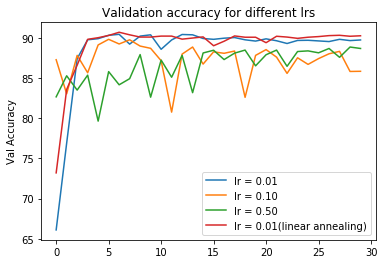

In [116]:
plt.clf()

for i in range(3):
    plt.plot(val_acc_total[i], label='lr = %.2f' % lrs[i])
plt.plot(val_acc_total[3], label='lr = 0.01(linear annealing)')
    
plt.title('Validation accuracy for different lrs')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('lr.png')
plt.show()

## Experiment for Max sentence length

In [130]:
N = 4
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
max_vocab_size = 40000

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

learning_rate = 0.01

In [135]:
MAX_SENTENCE_LENGTHs = [200, 500, 1200]

In [136]:
val_acc_total_msl = []

In [137]:
for MAX_SENTENCE_LENGTH in MAX_SENTENCE_LENGTHs:
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    model = BagOfWords(len(id2token), emb_dim)

    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer and scheduler
    criterion = torch.nn.CrossEntropyLoss()  

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    val_acc_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                scheduler.step(running_loss)
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_values.append(val_acc)
                if len(train_loader) - i < 100:
                    print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                                epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

    #             trn_acc = test_model(train_loader, model)
    #             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
    #                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
                running_loss = 0.0
    val_acc_total_msl.append(val_acc_values)

Epoch: [1/5], Step: [601/625], Loss: 31.6280, Val Acc: 87.1
Epoch: [2/5], Step: [601/625], Loss: 18.8370, Val Acc: 85.68
Epoch: [3/5], Step: [601/625], Loss: 12.6479, Val Acc: 85.64
Epoch: [4/5], Step: [601/625], Loss: 7.8727, Val Acc: 84.5
Epoch: [5/5], Step: [601/625], Loss: 4.7173, Val Acc: 84.5
Epoch: [1/5], Step: [601/625], Loss: 29.1900, Val Acc: 90.38
Epoch: [2/5], Step: [601/625], Loss: 12.5297, Val Acc: 89.5
Epoch: [3/5], Step: [601/625], Loss: 4.3598, Val Acc: 89.42
Epoch: [4/5], Step: [601/625], Loss: 0.5721, Val Acc: 89.12
Epoch: [5/5], Step: [601/625], Loss: 0.1014, Val Acc: 89.42
Epoch: [1/5], Step: [601/625], Loss: 26.4075, Val Acc: 90.62
Epoch: [2/5], Step: [601/625], Loss: 12.8026, Val Acc: 90.18
Epoch: [3/5], Step: [601/625], Loss: 3.6481, Val Acc: 89.78
Epoch: [4/5], Step: [601/625], Loss: 0.4504, Val Acc: 89.98
Epoch: [5/5], Step: [601/625], Loss: 0.1353, Val Acc: 89.82


In [129]:
len(val_acc_total_backup)

4

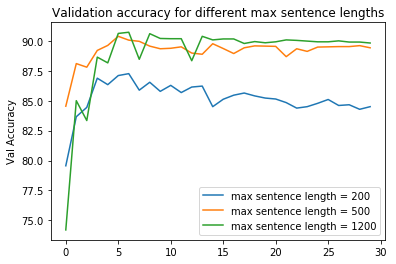

In [139]:
plt.clf()

for i in range(len(val_acc_total_msl)):
    plt.plot(val_acc_total_msl[i], label= 'max sentence length = %d' % MAX_SENTENCE_LENGTHs[i])
    
plt.title('Validation accuracy for different max sentence lengths')
plt.ylabel('Val Accuracy')
plt.legend()
plt.savefig('msl.png')
plt.show()

## Predicting Results

In [117]:
N = 4
train_data_tokens, all_train_tokens = ngrams_inclusive(train_data_tokens_, N)
val_data_tokens, _ = ngrams_inclusive(val_data_tokens_, N)
test_data_tokens, _ = ngrams_inclusive(test_data_tokens_, N)
MAX_SENTENCE_LENGTH = 1200
max_vocab_size = 40000

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

learning_rate = 0.01

In [118]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets, MAX_SENTENCE_LENGTH)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets, MAX_SENTENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets, MAX_SENTENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

val_acc_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            scheduler.step(running_loss)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_values.append(val_acc)
            if len(train_loader) - i < 100:
                print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Val Acc: {}'.format( 
                            epoch+1, num_epochs, i+1, len(train_loader), running_loss, val_acc))

#             trn_acc = test_model(train_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Trn Acc: {}, Val Acc: {}'.format( 
#                        epoch+1, num_epochs, i+1, len(train_loader), running_loss, trn_acc, val_acc))
            running_loss = 0.0
# val_acc_total.append(val_acc_values)

Epoch: [1/5], Step: [601/625], Loss: 30.8210, Val Acc: 89.52
Epoch: [2/5], Step: [601/625], Loss: 12.5483, Val Acc: 87.86
Epoch: [3/5], Step: [601/625], Loss: 3.6955, Val Acc: 88.26
Epoch: [4/5], Step: [601/625], Loss: 0.6112, Val Acc: 90.1
Epoch: [5/5], Step: [601/625], Loss: 0.1962, Val Acc: 90.26


In [119]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 5 epochs
Val Acc 90.12
Test Acc 88.6


In [120]:
def get_example(loader):
    rightPred = []
    wrongPred = []
    rightIdx = []
    wrongIdx = []
    model.eval()
    for i, (data, lengths, labels) in enumerate(loader):
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        pred = predicted.numpy().reshape(BATCH_SIZE)
        corr = labels.numpy()
        for j in range(BATCH_SIZE):
            if pred[j] == corr[j]:
                rightPred.append(pred[j])
                rightIdx.append(i*BATCH_SIZE+j)
            else:
                wrongPred.append(pred[j])
                wrongIdx.append(i*BATCH_SIZE+j)
        if len(rightPred) >= 3 and len(wrongPred) >= 3:
            return rightPred, wrongPred, rightIdx, wrongIdx

In [121]:
val_loader_example = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
rightPred, wrongPred, rightIdx, wrongIdx = get_example(val_loader_example)

In [122]:
print (val_data[rightIdx[0]])
print (val_targets[rightIdx[0]])
print (rightPred[0])

In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupted with a corpse that contains plague. As cop Paul Douglas properly points out the guy died from two bullets in the chest. That's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.As was pointed out by any number of people, for some reason director Elia Kazan did not bother to cast the small parts with anyone that sounds like they're from Louisiana. Having been to New Orleans where the story takes place I can personally attest to that. Richard Widmark and his wife Barbara Bel Geddes can be excused because as a Navy doctor he could be assigned there, but for those that are natives it doesn't work.But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld. The dead guy came off a ship from Europe and he had underworld connections. A New Orleans wise 

In [123]:
print (val_data[rightIdx[1]])
print (val_targets[rightIdx[1]])
print (rightPred[1])

If you ask me the first one was really better one. Look at Sarah M. G., she is real, mean, cruel girl, look at Amy Adams she is just little fool hanging around. She is nothing! People don't adore her! Second, Sebastian was cute and hot in first movie, now he is "baby face". Story is not that good, and i do not understand. Why didn't they make this one first, it is the beginning. Loosy actors, nothing with story. This is not cruel, this is playing. First one has better actors, better story, and its mean. I think that the music is better in cruel intentions 1 and the music is better in cruel intentions 3. It is not the worst movie I saw, but in compaer with first one its one big, big, big nothing.
0
0


In [124]:
print (val_data[rightIdx[2]])
print (val_targets[rightIdx[2]])
print (rightPred[2])

I am a big fan a Faerie Tale Theatre and I've seen them all and this is one of the best! It's funny, romantic, and a classic. I recommend this for all ages. It's great for little kids because it's well, Cinderella and great for adults and teen because it's funny and not over the top. I watched it when I was little and I still watch it now. It has great lines that my family and I quote all the time. The acting is great and it never gets old. If you like fairy tales and romances you will love this. I've watched many a Cinderella movie in my time and this is the best of them all. (Sorry Disney) I highly recommend this movie and all the Faerie Tale Theatre shows. They all appeal to all ages and are all unique and very entertaining.
1
1


In [125]:
print (val_data[wrongIdx[0]])
print (val_targets[wrongIdx[0]])
print (wrongPred[0])

This film would usually classify as the worst movie production ever. Ever. But in my opinion it is possibly the funniest. The horrifying direction and screenplay makes this film priceless. I bought the movie whilst sifting through the bargain DVD's at my local pound shop. Me and some friends then watched it, admittedly whilst rather drunk. It soon occurred that this wasn't any normal film. Instead a priceless relic of what will probably be James Cahill's last film. At first we were confused and were screaming for the DVD player to be turned off but thankfully in our abnormal state no-one could be bothered. Instead we watched the film right through. At the end we soon realised we had found any wasters dream, something that you can acceptably laugh at for hours, whilst laughing for all the wrong reasons. We soon showed all our other friends and they too agreed, this wasn't a work of abysmal film. This was a film that you can truly wet yourself laughing at. This was a film that anyone can

In [126]:
print (val_data[wrongIdx[1]])
print (val_targets[wrongIdx[1]])
print (wrongPred[1])

As a child the first installment ("The Little Mermaid") was my favorite movie. It was filled with great characters, songs, and a fun family film. A week or so again I watched this movie for the first time. I believe that this movie was like most sequels and didn't surpass their original. I think that I feel this way possibly because I had high expectations and I have grown up. However, it is not a bad film.It starts when Ariel has just given birth to a beautiful child, Melody. Eric and Ariel feel threatened by Morgana (Eurselas' sister), so they build a large wall around their house which lies on the sea. As Melody grows up she begins to wonder outside of the walls where she is forbidden to go. Trouble stirs up as Morgana tries to take control of the seven seas.I don't want to give away any of the movie so you have to see it to find out. I did like that the voices are the same and again wonderful singing. I think this is a good family film though overall!
0
1


In [127]:
print (val_data[wrongIdx[2]])
print (val_targets[wrongIdx[2]])
print (wrongPred[2])

For starters I have always been a fan of the Batman cartoons because the theme is so universal, 'that everyone alive has an alter-ego'. This is true in the Mystery of Batwoman. While the overall story is good I'm disappointed that they haven't really done much for the franchise with this.Throughout the movie, you are trying to find out who the identity of Batwoman is, unfortunately you can find out by easily looking at the cast of credits posted on this website (so if you haven't seen it already don't go there). I was sort of disappointed that they didn't make the movie longer. 75 minutes is way too short for any movie. The secret identity of batwoman also comes far too early in the movie, sort of midway, and becomes anti-climatic afterward because you know the good guys will always win and that the new character known as Batwoman will disappear after the movie is over.I'm also not too sure about the new animation style used in this movie. I love the sleek new characters but there shou